## Transfer Learning

In this mini-project we will use technique called Transfer Learning. Transfer learning let apply an existing trained model to a dataset we are intrested in. In this example we will use Inception v3 model.

### Prerequisites

Data we will use come from Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data. To have an access to this data, you have to create account on Kaggle and join this competition. 
Next, you have to download train folder, rename directory to 'kaggle_data' and place it in the same folder as this script.

In [15]:
import os, shutil

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import matplotlib.pyplot as plt

### Data

In kaggle dataset there are 25000 images of dogs and cats in one folder. Images are labeled by file names, for example cat will be on files 'cat.0.jpg', 'cat.1.jpg', and dogs on 'dog.0.jpg', 'dog.1.jpg'.
The biggest advantage of transfer learning is, that we don't have to use big dataset to have a good results so we will use only part of this dataset. First we will split data into directories for train set and test set and move cats and dogs into separate folders.

In [4]:
kaggle_dataset_dir = 'kaggle_data'
base_dir = 'data'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

Now we will copy files into our cats, and dogs foders so we will have 2000 training images (1000 per dogs and cats) and 1000 (500 per dogs and cats) test images

In [5]:
names = ['cat.{}.jpg'.format(i) for i in range(1000)]
for name in names:
    src = os.path.join(kaggle_dataset_dir, name)
    dst = os.path.join(train_cats_dir, name)
    shutil.copyfile(src, dst)
    
names = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for name in names:
    src = os.path.join(kaggle_dataset_dir, name)
    dst = os.path.join(test_cats_dir, name)
    shutil.copyfile(src, dst)

In [6]:
names = ['dog.{}.jpg'.format(i) for i in range(1000)]
for name in names:
    src = os.path.join(kaggle_dataset_dir, name)
    dst = os.path.join(train_dogs_dir, name)
    shutil.copyfile(src, dst)
    
names = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for name in names:
    src = os.path.join(kaggle_dataset_dir, name)
    dst = os.path.join(test_dogs_dir, name)
    shutil.copyfile(src, dst)

### Preprocessing

We have to preprocess data before it will be fed into our network. First we are normalizing values of pixels, then we create generators for training and test datasets. This generators will return another batch of 20 samples for each time they will be called, and each image size is adjusted to 150 x 150 pixels

In [7]:
train_image_gen = ImageDataGenerator(rescale=1./255)
test_image_gen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_image_gen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20)

test_generator = test_image_gen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Model

We are ready to build our model, in this project we don't want to build neural network from scratch, but we want to use pretrained Inception V3 network. This is large, very deep network trained on ImageNet dataset. Core idea of this netowrk is to have filters with multiple sizes operating on the same level. Following image present architecture of this network 

<img src="inception_v3_architecture.png">

In [9]:
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False)

In [10]:
x = InceptionV3_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)        
predictions = Dense(2, activation='softmax')(x) 

model = Model(inputs=InceptionV3_base_model.input, outputs=predictions)
print (model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Training - Option 2 - fine tuning

We can start to train our network, we will use technique called fine tuning. It means that we will freeze part of the network, so that weights of this layers will not change, and we will last remaining layers.

In [11]:
Layers_To_Freeze = 172
for layer in model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in model.layers[Layers_To_Freeze:]:
  layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history_fine_tune = model.fit_generator(
  train_generator,
  steps_per_epoch = 100,
  epochs=10,
  validation_data=test_generator,
  validation_steps = 50,
    class_weight='auto')

Epoch 1/10
100/100 [==============================] - 1618s 16s/step - loss: 0.5995 - acc: 0.6465 - val_loss: 0.5068 - val_acc: 0.7300
Epoch 2/10
100/100 [==============================] - 1529s 15s/step - loss: 0.4806 - acc: 0.7780 - val_loss: 0.2842 - val_acc: 0.8890
Epoch 3/10
100/100 [==============================] - 1127s 11s/step - loss: 0.4262 - acc: 0.8045 - val_loss: 0.3396 - val_acc: 0.8530
Epoch 4/10
100/100 [==============================] - 660s 7s/step - loss: 0.3695 - acc: 0.8420 - val_loss: 0.2921 - val_acc: 0.8750
Epoch 5/10
100/100 [==============================] - 673s 7s/step - loss: 0.3558 - acc: 0.8440 - val_loss: 0.2761 - val_acc: 0.8800
Epoch 6/10
100/100 [==============================] - 660s 7s/step - loss: 0.3264 - acc: 0.8645 - val_loss: 0.2313 - val_acc: 0.9000
Epoch 7/10
100/100 [==============================] - 656s 7s/step - loss: 0.2939 - acc: 0.8795 - val_loss: 0.2476 - val_acc: 0.8930
Epoch 8/10
100/100 [==============================] - 661s 7s/s

We will save our model, thi trining session cost me some time so I don't want to waste it.

In [13]:
model.save('inceptionv3-fine-tune.model')

Let's see how trainig accuracy and validation accuracy was calculated during training. 

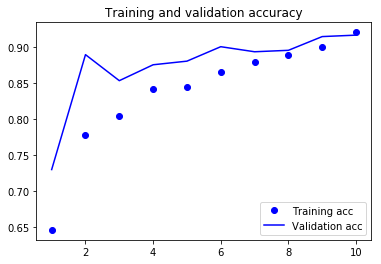

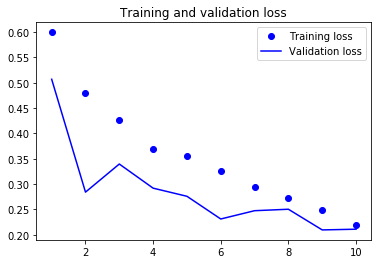

In [16]:
acc = history_fine_tune.history['acc']
val_acc = history_fine_tune.history['val_acc']
loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

What may look stange, validation accuracy is higher than training accuracy and validation loss is lower than training loss. Is it means that our model performs better on the test data than on trainig data ? No, this happens because of our dropout layer. During the training random part of this layer neurons are set to 0. This is how regularization is performed so our model is not overfitting, but because of that model is performing worse during the training. 

### Conclusion

It looks that our network works very well, just after 10 epochs we achieved accuracy over 90%. According to above graphs there is a lot of potential in this model, and we could aim in much higher accuracy.